In [1]:
import numpy as np
import pandas as pd
import scipy.stats

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('./data/combinedData.csv')
target = pd.read_csv('./data/combinedTarget.csv')

/usr/local/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (10,13,14,24) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
data = data.merge(target, how='left',on=['Provider','Set'])

In [127]:
data[data.Set=='Test']

,Unnamed: 0_x,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,...,OPAnnualDeductibleAmt,WhetherDead,NumChronics,NumProc,NumDiag,AdmissionDays,ClaimDays,Age,Unnamed: 0_y,PotentialFraud
166313,166313,BENE11014,CLM67387,2009-09-09,2009-09-16,PRV57070,9000,PHY317786,PHY427017,NaN,...,100,0,5,2,11,8.0,8,71.0,6645,?
166314,166314,BENE11014,CLM731858,2009-12-16,2009-12-16,PRV56558,60,PHY331420,PHY331420,PHY428520,...,100,0,5,0,2,NaN,1,72.0,6522,?
166315,166315,BENE11017,CLM31237,2008-12-25,2009-01-08,PRV54750,14000,PHY314656,PHY426644,NaN,...,840,0,9,1,10,15.0,15,69.0,6154,?
166316,166316,BENE11026,CLM78930,2009-12-09,2009-12-13,PRV53758,2000,PHY349495,NaN,NaN,...,0,0,1,0,10,5.0,5,72.0,5950,?
166317,166317,BENE11031,CLM56810,2009-06-23,2009-07-06,PRV55825,16000,PHY429538,PHY371893,NaN,...,0,0,4,2,11,14.0,14,65.0,6375,?
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
693598,693598,BENE159193,CLM469576,2009-07-14,2009-07-14,PRV55485,70,PHY431265,NaN,NaN,...,50,0,0,0,1,NaN,1,73.0,6318,?
693599,693599,BENE159193,CLM483842,2009-07-22,2009-07-22,PRV55485,10,PHY369098,NaN,NaN,...,50,0,0,0,4,NaN,1,73.0,6318,?
693600,693600,BENE159193,CLM554925,2009-08-31,2009-08-31,PRV55485,30,PHY431298,NaN,NaN,...,50,0,0,0,3,NaN,1,73.0,6318,?
693601,693601,BENE159194,CLM347777,2009-05-08,2009-05-08,PRV55889,30,PHY406767,NaN,PHY406767,...,460,0,1,0,5,NaN,1,70.0,6389,?


In [ ]:
data.groupby('BeneID')['Provider'].nunique()

In [12]:
physData = data[['AttendingPhysician','OperatingPhysician','OtherPhysician','Provider','State','PotentialFraud']]
physMelt = physData.melt(id_vars=['Provider','State','PotentialFraud'],var_name='Type', value_name='Doctor').dropna(axis=0).drop_duplicates()
physNet = physMelt.groupby(['Doctor','PotentialFraud'])['Provider'].nunique().reset_index()

In [16]:
fraudCount = physNet.groupby(['Provider','PotentialFraud'])['Doctor'].count().reset_index()

In [19]:
import numpy as np
fraudCount['logCount'] = np.log(fraudCount.Doctor+1)

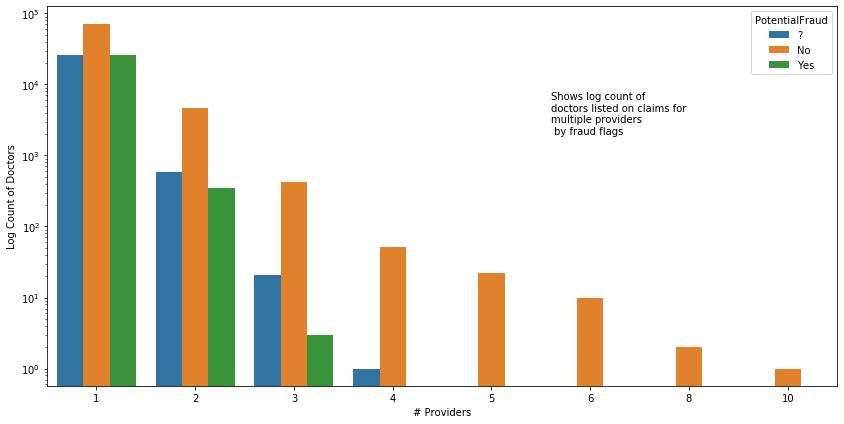

In [79]:
plt.figure(figsize=(12,6))


ax2 = sns.barplot(x = 'Provider',y = 'Doctor', hue = 'PotentialFraud', data = fraudCount)
ax2.set(xlabel='# Providers', ylabel = 'Log Count of Doctors')
plt.tight_layout()
ax2.set(yscale="log")
plt.annotate('Shows log count of \ndoctors listed on claims for \nmultiple providers\n by fraud flags', (4.6, 2000.5))

ax2.figure.savefig("./visualizations/plots/numProviders.png",bbox_inches='tight')

In [ ]:
physNet.groupby('State').count()

In [65]:
beneData = data[['BeneID','Provider','PotentialFraud']]
beneNet = beneData.groupby(['BeneID','PotentialFraud'])['Provider'].nunique().reset_index()

In [144]:
d = data.groupby(['Age','PotentialFraud'])['Provider'].nunique().reset_index()
pivoted = d.pivot_table(values='Provider', index = 'Age', columns='PotentialFraud')
# ax1 = sns.lineplot(x = 'Age', y = 'Provider', hue = 'PotentialFraud', data = d)
# ax1.set(yscale="log")

In [188]:
pivot_scale = (pivoted[['?','No','Yes']] - pivoted.mean(axis=0))/pivoted.std(axis=0)

In [162]:
pivot_scale = pivot_scale.reset_index()

In [166]:
pivot_scale = pivot_scale.melt(id_vars = 'Age')

In [241]:
def plot_count_across_fraud(data, feature, plotType = 'line'):
    d = data.groupby([feature,'PotentialFraud'])['Provider'].nunique().reset_index()
    pivoted = d.pivot_table(values='Provider', index = feature, columns='PotentialFraud')
    pivot_scale = (pivoted[['?','No','Yes']] - pivoted.mean(axis=0))/pivoted.std(axis=0)
    pivot_scale = pivot_scale.reset_index()
    d_scaled = pivot_scale.melt(id_vars = feature)
    
    if plotType == 'line':
        ax1 = sns.lineplot(x = feature, hue = 'PotentialFraud', y = 'value', data=d_scaled)
    elif plotType == 'scatter':
        ax1 = sns.scatterplot(x = feature, hue = 'PotentialFraud', y = 'value', data=d_scaled)
    ax1.set(title='Standardized Number of Providers\n that filed Claims matching this Feature')
    plt.tight_layout()
    return



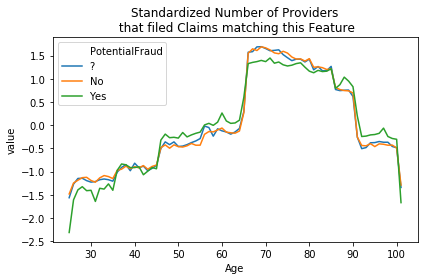

In [245]:
plot_count_across_fraud(data, 'Age')


In [223]:
d = data.groupby(['Age','PotentialFraud'])['ClaimID'].count().reset_index()
pivoted = d.pivot_table(values='ClaimID', index = 'Age', columns='PotentialFraud')
pivot_scale = (pivoted[['?','No','Yes']] - pivoted.mean(axis=0))/pivoted.std(axis=0)
pivot_scale = pivot_scale.reset_index()
d_scaled = pivot_scale.melt(id_vars = 'Age')

In [235]:
data.columns

Index(['Unnamed: 0_x', 'BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt',
       'Provider', 'InscClaimAmtReimbursed', 'AttendingPhysician',
       'OperatingPhysician', 'OtherPhysician', 'AdmissionDt',
       'ClmAdmitDiagnosisCode', 'DeductibleAmtPaid', 'DischargeDt',
       'DiagnosisGroupCode', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',
       'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5',
       'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8',
       'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 'ClmProcedureCode_1',
       'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4',
       'ClmProcedureCode_5', 'ClmProcedureCode_6', 'Set', 'Status', 'DOB',
       'DOD', 'Gender', 'Race', 'RenalDiseaseIndicator', 'State', 'County',
       'NoOfMonths_PartACov', 'NoOfMonths_PartBCov', 'Alzheimer',
       'HeartFailure', 'KidneyDisease', 'Cancer', 'ObstrPulmonary',
       'Depression', 'Diabetes', 'IschemicHeart', 'Osteoporasis',
       'Rheu

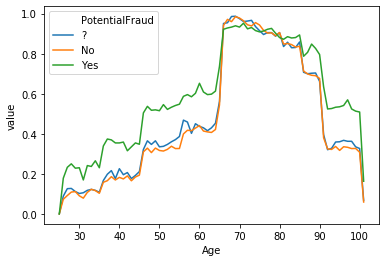

In [169]:

ax1 = sns.lineplot(x = 'Age', hue = 'PotentialFraud', y = 'value', data=pivot_scale)

#ax1.set(xlabel='# Providers', ylabel='Log Count of Patients')

#plt.annotate('Shows log count of patients that are on claims filed at \nmultiple providers by fraud flags', (8.6, 10005))

#plt.tight_layout()
#ax1.figure.savefig("./visualizations/plots/multiProvider-Bene.png",bbox_inches='tight')

In [90]:
data.groupby(['Status','WhetherDead'])['BeneID'].count().reset_index()

,Status,WhetherDead,BeneID
0,in,0,49646
1,in,1,379
2,out,0,638786
3,out,1,4792


In [92]:
print(379/(379+49646))
print(4792/(4792+638786))


0.007576211894052973
0.007445872916724935


In [96]:
data.groupby(['Status','PotentialFraud'])['ClaimID'].count().reset_index().head(20)

,Status,PotentialFraud,ClaimID
0,in,?,9551
1,in,No,17072
2,in,Yes,23402
3,out,?,125841
4,out,No,328343
5,out,Yes,189394


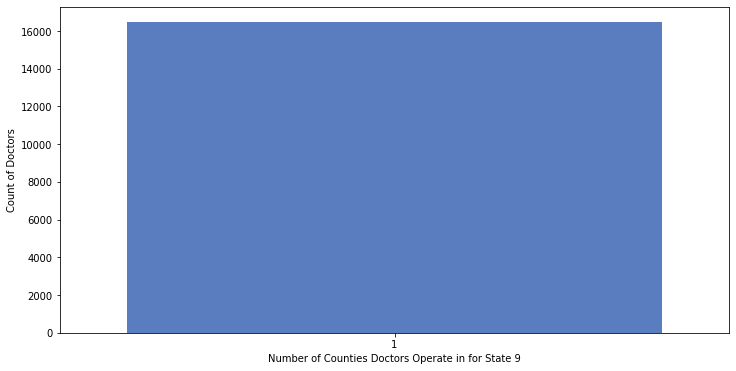

In [5]:
physData = data[['AttendingPhysician','OperatingPhysician','OtherPhysician','State','County']]
physMelt = physData.melt(id_vars=['State','County'],var_name='Type', value_name='Doctor').dropna(axis=0)
physNet = physMelt.groupby(['Doctor','State'])['County'].nunique().reset_index()

plt.figure(figsize=(12,6))

for state in physNet.State.unique():
    filename = "./visualizations/plots/crossing_county/Doctors/State_" + str(state) + ".png"
    ax1 = sns.countplot(x = 'County', data=physNet[physNet.State==state], palette = 'muted');
    ax1.set(xlabel='Number of Counties Doctors Operate in for State ' + str(state), 
            ylabel='Count of Doctors');
    ax1.figure.savefig(filename,bbox_inches='tight')

In [ ]:
beneData = data[['BeneID','Provider','State','County']]
beneNet = beneData.groupby(['BeneID','Provider'])['County'].nunique().reset_index()

plt.figure(figsize=(12,6))


ax1 = sns.countplot(x = 'County', data=beneNet, palette = 'muted')

ax1.set(xlabel='Number of Counties', ylabel='Number of Doctors')

#ax1.figure.savefig("./visualizations/plots/multistateDoctors.png",bbox_inches='tight')

In [252]:
target.copy(deep=True)

,Unnamed: 0,PotentialFraud,Provider,Set
0,0,No,PRV51001,Train
1,1,Yes,PRV51003,Train
2,2,No,PRV51004,Train
3,3,Yes,PRV51005,Train
4,4,No,PRV51007,Train
...,...,...,...,...
6758,6758,?,PRV57713,Test
6759,6759,?,PRV57726,Test
6760,6760,?,PRV57745,Test
6761,6761,?,PRV57749,Test


In [248]:
data.groupby('Provider')['State'].nunique().to_dict()

{'PRV51001': 1,
 'PRV51002': 4,
 'PRV51003': 3,
 'PRV51004': 9,
 'PRV51005': 4,
 'PRV51006': 2,
 'PRV51007': 2,
 'PRV51008': 2,
 'PRV51009': 1,
 'PRV51010': 1,
 'PRV51011': 1,
 'PRV51012': 3,
 'PRV51013': 2,
 'PRV51014': 2,
 'PRV51015': 1,
 'PRV51016': 1,
 'PRV51017': 10,
 'PRV51018': 2,
 'PRV51019': 2,
 'PRV51020': 2,
 'PRV51021': 4,
 'PRV51022': 2,
 'PRV51023': 1,
 'PRV51024': 2,
 'PRV51025': 2,
 'PRV51026': 3,
 'PRV51027': 2,
 'PRV51028': 1,
 'PRV51029': 6,
 'PRV51030': 2,
 'PRV51031': 4,
 'PRV51032': 3,
 'PRV51033': 1,
 'PRV51034': 1,
 'PRV51035': 2,
 'PRV51036': 1,
 'PRV51037': 1,
 'PRV51038': 3,
 'PRV51039': 3,
 'PRV51040': 2,
 'PRV51041': 1,
 'PRV51042': 9,
 'PRV51043': 2,
 'PRV51044': 1,
 'PRV51045': 3,
 'PRV51046': 1,
 'PRV51047': 2,
 'PRV51048': 1,
 'PRV51049': 4,
 'PRV51050': 4,
 'PRV51051': 1,
 'PRV51052': 1,
 'PRV51053': 1,
 'PRV51054': 1,
 'PRV51055': 1,
 'PRV51056': 1,
 'PRV51057': 1,
 'PRV51058': 2,
 'PRV51059': 1,
 'PRV51060': 2,
 'PRV51061': 2,
 'PRV51062': 1,
 'PRV51

Text(1000.6, 105, 'Fraud: No')

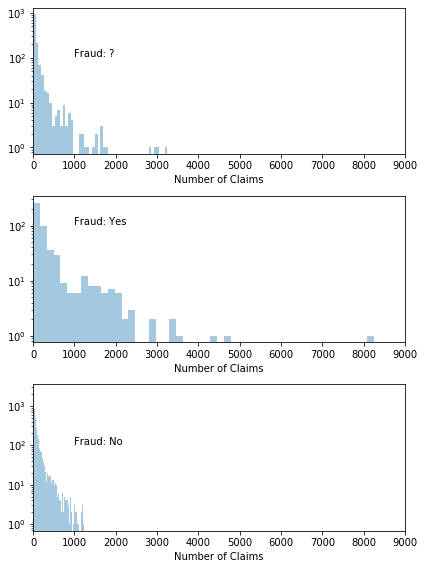

In [126]:
plt.figure(figsize=(6,8))

ax1 = plt.subplot(311)

ax1 = sns.distplot(a = numClaims[numClaims.PotentialFraud=='?']['ClaimID'], kde=False)
ax1.set(yscale="log")
ax1.set(xlabel='Number of Claims')
plt.tight_layout()
plt.xlim(0,9000)
plt.annotate('Fraud: ?', (1000.6, 105))


ax2 = plt.subplot(312)
ax2 = sns.distplot(a = numClaims[numClaims.PotentialFraud=='Yes']['ClaimID'], kde=False)
ax2.set(yscale="log")
ax2.set(xlabel='Number of Claims')
plt.tight_layout()
plt.xlim(0,9000)
plt.annotate('Fraud: Yes', (1000.6, 105))

ax3 = plt.subplot(313)
ax3 = sns.distplot(a = numClaims[numClaims.PotentialFraud=='No']['ClaimID'], kde=False)
ax3.set(yscale="log")
ax3.set(xlabel='Number of Claims')
plt.tight_layout()
plt.xlim(0,9000)
plt.annotate('Fraud: No', (1000.6, 105))

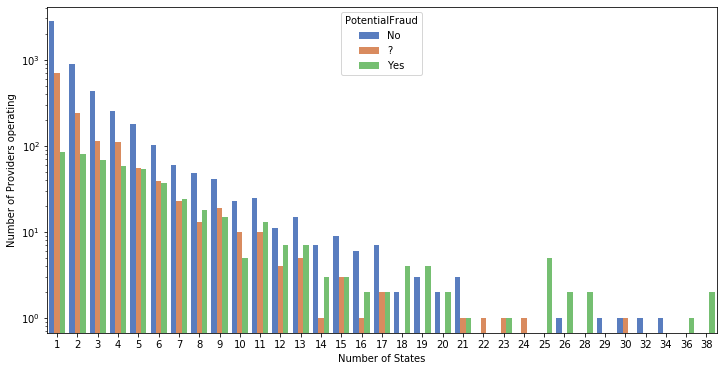

In [103]:
provData = data[['Provider','PotentialFraud','State','County']]
provNet = provData.groupby(['Provider','PotentialFraud'])['State'].nunique().reset_index()

plt.figure(figsize=(12,6))


ax1 = sns.countplot(x = 'State', hue = 'PotentialFraud', data=provNet, palette = 'muted')

ax1.set(xlabel='Number of States', ylabel='Number of Providers operating')
ax1.set(yscale="log")
ax1.figure.savefig("./visualizations/plots/multistateProviders.png",bbox_inches='tight')

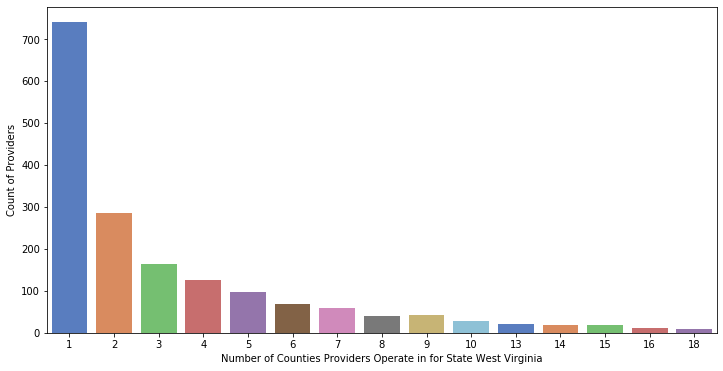

In [57]:
provData = data[['Provider','State','County']]
provNet = provData.groupby(['Provider','State'])['County'].nunique().reset_index().drop_duplicates()

plt.figure(figsize=(12,6))

for state in provNet.State.unique():
    filename = "./visualizations/plots/crossing_county/Providers/State_" + str(state) + ".png"
    ax1 = sns.countplot(x = 'County', data=provNet[provNet.State==state], palette = 'muted');
    ax1.set(xlabel='Number of Counties Providers Operate in for State ' + str(state), 
            ylabel='Count of Providers');
    ax1.figure.savefig(filename,bbox_inches='tight')

In [6]:
physData = data[['AttendingPhysician','OperatingPhysician','OtherPhysician','Provider']]
physMelt = physData.melt(id_vars=['State','County'],var_name='Type', value_name='Doctor').dropna(axis=0)
physNet = physMelt.groupby(['State','County'])['Doctor'].nunique().reset_index()


In [262]:
d = data.melt(id_vars = 'Provider', value_vars = ['AttendingPhysician',
                     'OperatingPhysician',
                     'OtherPhysician'], var_name='Type', value_name='Doctor').dropna(axis=0)
d = d[['Provider','Doctor']].drop_duplicates()

In [268]:
provData['numDocs'] = d.groupby('Provider')['Doctor'].count().values

In [265]:
provData = data.groupby('Provider').agg({'BeneID':'nunique',
                              'ClaimID' : 'count',
                              'State' : 'nunique'}).reset_index()

In [272]:
data.groupby('Provider').agg({'NumDiag':['min','max']}).reset_index()

Provider NumDiag    
                   min max
0     PRV51001       1  10
1     PRV51002       0   9
2     PRV51003       1  11
3     PRV51004       0   9
4     PRV51005       0  10
...        ...     ...  ..
6758  PRV57759       0   5
6759  PRV57760       1   8
6760  PRV57761       1   9
6761  PRV57762       2   2
6762  PRV57763       0  10

[6763 rows x 3 columns]

In [21]:
california = physNet[physNet.State==5]

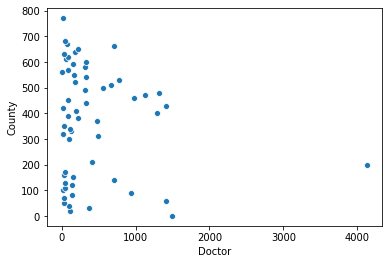

In [23]:
sns.scatterplot(x = 'Doctor', y = 'County',data = california)

In [ ]:
for state in physNet.State.unique():
    filename = "./visualizations/plots/num_doctors/State_" + str(state) + ".png"
    ax1 = sns.countplot(x = 'County', data=physNet[physNet.State==state], palette = 'muted');
    ax1.set(xlabel='Number of Doctors' + str(state), 
            ylabel='Count of Doctors');
    ax1.figure.savefig(filename,bbox_inches='tight')

In [26]:
data.WhetherDead.value_counts()

0    688432
1      5171
Name: WhetherDead, dtype: int64

In [29]:
5171/(5171+688432)*100


0.7455273405680194

In [285]:
p = pd.read_csv('./data/provData.csv')

In [290]:
import os
try:
    os.mkdir('./b')
except:
    pass

In [277]:
provData = data.groupby(['Provider','Set']).agg({
		'BeneID':'nunique',
		'ClaimID' : 'count',
		'State' : 'nunique',
		}).reset_index()

In [347]:
d = data.groupby(['Provider','Status']).agg({'ClaimID': 'count',
                                             'BeneID' : 'nunique'}).reset_index().pivot_table(values=['ClaimID','BeneID'], index = 'Provider', columns='Status').fillna(0)

In [348]:
d = d.reset_index()
d.columns = d.columns.map(''.join)
d

,Provider,BeneIDin,BeneIDout,ClaimIDin,ClaimIDout
0,PRV51001,5.0,19.0,5.0,20.0
1,PRV51002,0.0,169.0,0.0,205.0
2,PRV51003,53.0,66.0,62.0,70.0
3,PRV51004,0.0,138.0,0.0,149.0
4,PRV51005,0.0,495.0,0.0,1165.0
...,...,...,...,...,...
6758,PRV57759,0.0,24.0,0.0,28.0
6759,PRV57760,0.0,9.0,0.0,22.0
6760,PRV57761,0.0,67.0,0.0,82.0
6761,PRV57762,0.0,1.0,0.0,1.0


In [279]:
provData.merge(target, on = ['Provider','Set'], how = 'left')

,Provider,Set,BeneID,ClaimID,State,Unnamed: 0,PotentialFraud
0,PRV51001,Train,24,25,1,0,No
1,PRV51002,Test,169,205,4,5410,?
2,PRV51003,Train,117,132,3,1,Yes
3,PRV51004,Train,138,149,9,2,No
4,PRV51005,Train,495,1165,4,3,Yes
...,...,...,...,...,...,...,...
6758,PRV57759,Train,24,28,1,5405,No
6759,PRV57760,Train,9,22,1,5406,No
6760,PRV57761,Train,67,82,1,5407,No
6761,PRV57762,Train,1,1,1,5408,No


In [283]:
target_train = pd.read_csv('./data/Train.csv')



In [284]:
target_train

,Provider,PotentialFraud
0,PRV51001,No
1,PRV51003,Yes
2,PRV51004,No
3,PRV51005,Yes
4,PRV51007,No
...,...,...
5405,PRV57759,No
5406,PRV57760,No
5407,PRV57761,No
5408,PRV57762,No


In [350]:
x_train = pd.read_csv('./data/provData/x_train.csv')
x_test = pd.read_csv('./data/provData/x_test.csv')

In [351]:
x_train

,Unnamed: 0,Provider,BeneID,ClaimID,State,BeneIDin,BeneIDout,ClaimIDin,ClaimIDout,Doctors,PotentialFraud
0,0,PRV51001,24,25,1,5.0,19.0,5.0,20.0,19,No
1,2,PRV51003,117,132,3,53.0,66.0,62.0,70.0,51,Yes
2,3,PRV51004,138,149,9,0.0,138.0,0.0,149.0,48,No
3,4,PRV51005,495,1165,4,0.0,495.0,0.0,1165.0,7,Yes
4,6,PRV51007,58,72,2,3.0,56.0,3.0,69.0,11,No
...,...,...,...,...,...,...,...,...,...,...,...
5405,6758,PRV57759,24,28,1,0.0,24.0,0.0,28.0,1,No
5406,6759,PRV57760,9,22,1,0.0,9.0,0.0,22.0,3,No
5407,6760,PRV57761,67,82,1,0.0,67.0,0.0,82.0,7,No
5408,6761,PRV57762,1,1,1,0.0,1.0,0.0,1.0,1,No


In [349]:
x.merge(d, on='Provider', how='left')

,BeneID,ClaimID,Doctors,PotentialFraud,Provider,State,Unnamed: 0,BeneIDin,BeneIDout,ClaimIDin,ClaimIDout
0,24,25,19,No,PRV51001,1,0,5.0,19.0,5.0,20.0
1,117,132,51,Yes,PRV51003,3,2,53.0,66.0,62.0,70.0
2,138,149,48,No,PRV51004,9,3,0.0,138.0,0.0,149.0
3,495,1165,7,Yes,PRV51005,4,4,0.0,495.0,0.0,1165.0
4,58,72,11,No,PRV51007,2,6,3.0,56.0,3.0,69.0
...,...,...,...,...,...,...,...,...,...,...,...
6758,10,11,7,NaN,PRV57713,1,6712,0.0,10.0,0.0,11.0
6759,8,8,5,NaN,PRV57726,1,6725,0.0,8.0,0.0,8.0
6760,2,2,1,NaN,PRV57745,1,6744,0.0,2.0,0.0,2.0
6761,45,49,2,NaN,PRV57749,1,6748,0.0,45.0,0.0,49.0


In [346]:
d

,Provider_,BeneID_in,BeneID_out,ClaimID_in,ClaimID_out
0,PRV51001,5.0,19.0,5.0,20.0
1,PRV51002,0.0,169.0,0.0,205.0
2,PRV51003,53.0,66.0,62.0,70.0
3,PRV51004,0.0,138.0,0.0,149.0
4,PRV51005,0.0,495.0,0.0,1165.0
...,...,...,...,...,...
6758,PRV57759,0.0,24.0,0.0,28.0
6759,PRV57760,0.0,9.0,0.0,22.0
6760,PRV57761,0.0,67.0,0.0,82.0
6761,PRV57762,0.0,1.0,0.0,1.0
